<a href="https://colab.research.google.com/github/Seyed-Ali-Ahmadi/Building-Damage-Assessment/blob/master/02_Create_image_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this file I have tried to extract useful texture featuers. In each section, different methods of a technique are tried.

# 1- Local binary Pattern

In [1]:
# import the necessary packages
from skimage import feature
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np

In [3]:
rootDir = '/content/drive/My Drive/subset_images/'
image = imread(rootDir + 'guatemala-volcano_00000000_post_disaster.png')
image = image[:, :, 0]

# settings for LBP
radius = 1
n_points = 8 * radius
lbp = feature.local_binary_pattern(image, n_points, radius, method="uniform")

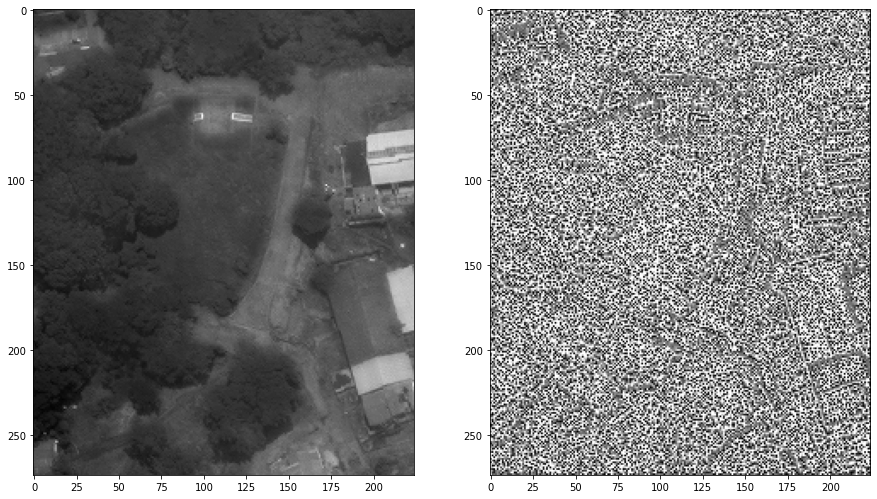

In [4]:
plt.figure(figsize=(15, 12))
plt.subplot(121), plt.imshow(image[750:, 800:], cmap='gray')
plt.subplot(122), plt.imshow(lbp[750:, 800:], cmap='gray')
plt.show()

# 2- Gray-Level Co-Occurrance Matrix

PAD and W are the parameters.

W is the Width of the image

PAD is the neighborhood

In [5]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import tqdm
from skimage.io import imread
from skimage.feature import greycomatrix, greycoprops
from multiprocessing import Pool

In [6]:
def glcm_props(patch):
    lf = []
    props = ['dissimilarity', 'contrast', 'homogeneity', 'energy', 'correlation']

    # left nearest neighbor
    glcm = greycomatrix(patch, [1], [0], 256, symmetric=True, normed=True)
    for f in props:
        lf.append( greycoprops(glcm, f)[0,0] )

    # upper nearest neighbor
    glcm = greycomatrix(patch, [1], [np.pi/2], 256, symmetric=True, normed=True)
    for f in props:
        lf.append( greycoprops(glcm, f)[0,0] )
        
    return lf


def patch_gen(img1, PAD=1):

    W = 50
    imgx = np.zeros((W + PAD * 2, W + PAD * 2), dtype=img1.dtype)
    imgx[PAD:W + PAD, PAD:W + PAD] = img1
    imgx[:PAD,  PAD:W+PAD] = img1[PAD:0:-1, :]
    imgx[-PAD:, PAD:W+PAD] = img1[W - 1:-PAD - 1:-1, :]
    imgx[:, :PAD ] = imgx[:, PAD * 2:PAD:-1]
    imgx[:, -PAD:] = imgx[:, W + PAD - 1:-PAD * 2 - 1:-1]

    xx, yy = np.meshgrid(np.arange(0, W), np.arange(0, W))
    xx, yy = xx.flatten() + PAD, yy.flatten() + PAD

    for x, y in zip(xx, yy):
        patch = imgx[y-PAD:y+PAD+1, x-PAD:x+PAD+1]
        yield patch


def glcm_feature(img, verbose=False):
    
    W, NF, PAD = 50, 10, 1

    if img.sum() == 0:
        return np.zeros((W,W,NF), dtype=np.float32)
    
    l = []
    with Pool(3) as pool:
        for p in tqdm.tqdm(pool.imap(glcm_props, patch_gen(img, PAD)), 
                           total=W * W, disable=not verbose):
            l.append(p)
        
    fimg = np.array(l, dtype=np.float32).reshape(W, W, -1)
    return fimg


def visualize_glcm(img):
    fimg = glcm_feature(img, verbose=1)
    
    _, (ax0, ax1) = plt.subplots(1, 2, figsize=(6,3))
    ax0.imshow(img)
    plt.show()
    
    amin = np.amin(fimg, axis=(0,1))
    amax = np.amax(fimg, axis=(0,1))
    fimg = (fimg - amin) / (amax - amin)

    fimg[...,4] = np.power(fimg[...,4], 3)
    fimg[...,9] = np.power(fimg[...,9], 3)

    _, axs = plt.subplots(2, 5, figsize=(15,6))
    axs = axs.flatten()

    for k in range(fimg.shape[-1]):
        axs[k].imshow(fimg[...,k])
    plt.show()

100%|██████████| 2500/2500 [00:21<00:00, 114.71it/s]


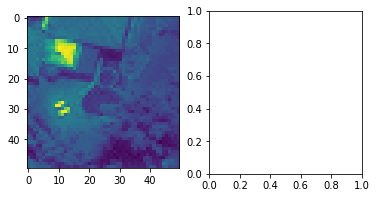

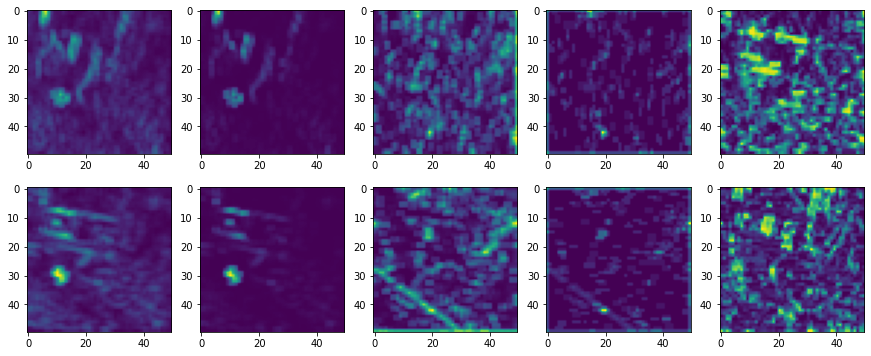

In [7]:
rootDir = '/content/drive/My Drive/subset_images/'
image = imread(rootDir + 'guatemala-volcano_00000007_post_disaster.png')
image = image[450:500, 800:850, 1]

visualize_glcm(image)

## 2.1 GLCM my own trying


(-0.5, 49.5, 49.5, -0.5)

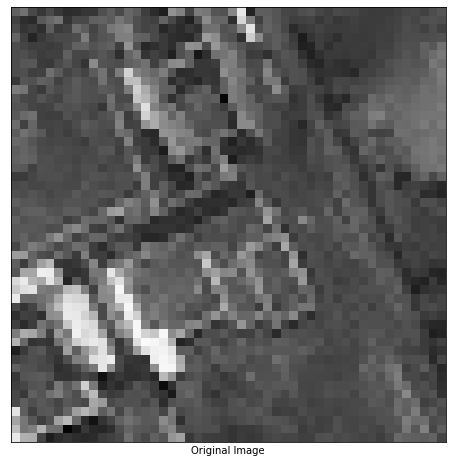

In [11]:
import matplotlib.pyplot as plt
from skimage.feature import greycomatrix, greycoprops


rootDir = '/content/drive/My Drive/subset_images/'
image = imread(rootDir + 'guatemala-volcano_00000007_post_disaster.png')
patch = image[450:500, 750:800, 0]

# compute some GLCM properties each patch
xs = []
ys = []
glcm = greycomatrix(patch, distances=[5], angles=[0], levels=256,
                    symmetric=True, normed=True)
xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
ys.append(greycoprops(glcm, 'correlation')[0, 0])

# create the figure
fig = plt.figure(figsize=(8, 8))

# display original image with locations of patches
ax = fig.add_subplot(111)
ax.imshow(patch, cmap=plt.cm.gray,
          vmin=0, vmax=255)
ax.set_xlabel('Original Image')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')

array([[20.02844444]])

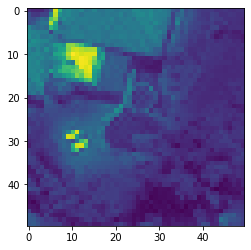

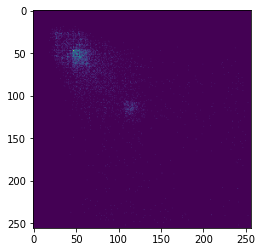

In [12]:
crop = image[450:500, 800:850, 0]
plt.figure()
plt.imshow(crop)

glcm = greycomatrix(crop, distances=[5], angles=[0], levels=256,
                    symmetric=True, normed=True)
plt.figure()
plt.imshow(glcm.reshape((256, 256)))

greycoprops(glcm, 'dissimilarity')

## 2.2 Start from here


In [13]:
from skimage.io import imread

rootDir = '/content/drive/My Drive/subset_images/'
image = imread(rootDir + 'guatemala-volcano_00000007_post_disaster.png')
crop = image[450:500, 800:850, 0]

In [14]:
import numpy as np

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """
    A sliding window function that moves the kernel over the image and 
    computes the probability of vehicle existence in kernels.
    This can be later used to approximate vehicle detections and further 
    enhance the results.

    https://github.com/JunshengFu/vehicle-detection/blob/master/svm_pipeline.py
    """
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] is None:
        x_start_stop[0] = 0
    if x_start_stop[1] is None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] is None:
        y_start_stop[0] = 0
    if y_start_stop[1] is None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0] * (xy_overlap[0]))
    ny_buffer = np.int(xy_window[1] * (xy_overlap[1]))
    nx_windows = np.int((xspan - nx_buffer) / nx_pix_per_step)
    ny_windows = np.int((yspan - ny_buffer) / ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [15]:
patches_list = slide_window(crop, xy_window=(5, 5), xy_overlap=(0.5, 0.5))

In [16]:
from skimage.feature import greycomatrix, greycoprops
import matplotlib.pyplot as plt


W, H = int(crop.shape[0]/2), int(crop.shape[1]/2)

crop_dissimilarity = np.zeros((H-1, W-1))
crop_contrast =      np.zeros((H-1, W-1))
crop_homogeneity =   np.zeros((H-1, W-1))
crop_ASM =           np.zeros((H-1, W-1))
crop_energy =        np.zeros((H-1, W-1))
crop_correlation =   np.zeros((H-1, W-1))


for patch in patches_list:
  xs = patch[0][0]
  xe = patch[1][0]
  ys = patch[0][1]
  ye = patch[1][1]
  glcm = greycomatrix(crop[ys:ye, xs:xe], distances=[2], 
                      angles=[90], levels=256,
                      symmetric=True, normed=True)
  
  crop_dissimilarity[int(ys/2), int(xs/2)] =  greycoprops(glcm, 'dissimilarity')
  crop_contrast[int(ys/2), int(xs/2)] =       greycoprops(glcm, 'contrast')
  crop_homogeneity[int(ys/2), int(xs/2)] =    greycoprops(glcm, 'homogeneity')
  crop_ASM[int(ys/2), int(xs/2)] =            greycoprops(glcm, 'ASM')
  crop_energy[int(ys/2), int(xs/2)] =         greycoprops(glcm, 'energy')
  crop_correlation[int(ys/2), int(xs/2)] =    greycoprops(glcm, 'correlation')

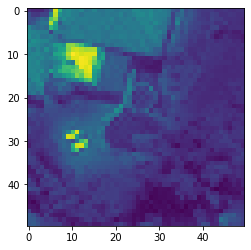

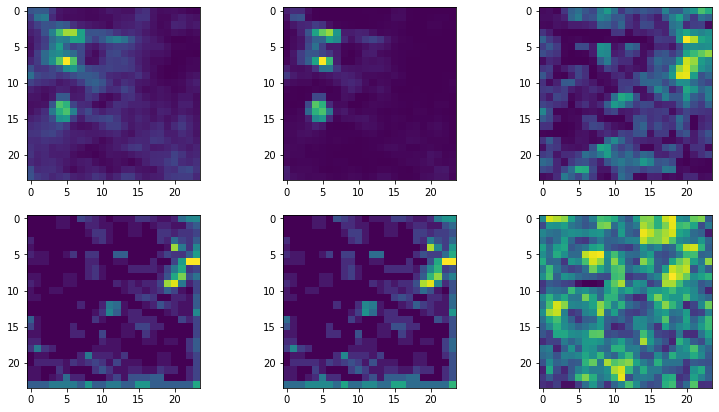

In [17]:
plt.figure()
plt.imshow(crop)

plt.figure(figsize=(13, 7))
plt.subplot(231), plt.imshow(crop_dissimilarity)
plt.subplot(232), plt.imshow(crop_contrast)
plt.subplot(233), plt.imshow(crop_homogeneity)
plt.subplot(234), plt.imshow(crop_ASM)
plt.subplot(235), plt.imshow(crop_energy)
plt.subplot(236), plt.imshow(crop_correlation)
plt.show()

## 2.3 Method II

In [18]:
# coding: utf-8

import numpy as np
import matplotlib.pyplot as plt
import cv2


def main():
    pass


def fast_glcm(img, vmin=0, vmax=255, nbit=8, kernel_size=5):
    mi, ma = vmin, vmax
    ks = kernel_size
    h,w = img.shape[0], img.shape[1]

    # digitize
    bins = np.linspace(mi, ma+1, nbit+1)
    gl1 = np.digitize(img, bins) - 1
    gl2 = np.append(gl1[:,1:], gl1[:,-1:], axis=1)

    # make glcm
    glcm = np.zeros((nbit, nbit, h, w), dtype=np.uint8)
    for i in range(nbit):
        for j in range(nbit):
            mask = ((gl1==i) & (gl2==j))
            glcm[i,j, mask] = 1

    kernel = np.ones((ks, ks), dtype=np.uint8)
    for i in range(nbit):
        for j in range(nbit):
            glcm[i,j] = cv2.filter2D(glcm[i,j], -1, kernel)

    glcm = glcm.astype(np.float32)
    return glcm


def fast_glcm_mean(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm mean
    '''
    h,w = img.shape[0], img.shape[1]
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    mean = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            mean += glcm[i,j] * i / (nbit)**2

    return mean


def fast_glcm_std(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm std
    '''
    h,w = img.shape[0], img.shape[1]
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    mean = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            mean += glcm[i,j] * i / (nbit)**2

    std2 = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            std2 += (glcm[i,j] * i - mean)**2

    std = np.sqrt(std2)
    return std


def fast_glcm_contrast(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm contrast
    '''
    h,w = img.shape[0], img.shape[1]
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    cont = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            cont += glcm[i,j] * (i-j)**2

    return cont


def fast_glcm_dissimilarity(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm dissimilarity
    '''
    h,w = img.shape[0], img.shape[1]
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    diss = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            diss += glcm[i,j] * np.abs(i-j)

    return diss


def fast_glcm_homogeneity(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm homogeneity
    '''
    h,w = img.shape[0], img.shape[1]
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    homo = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            homo += glcm[i,j] / (1.+(i-j)**2)

    return homo


def fast_glcm_ASM(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm asm, energy
    '''
    h,w = img.shape[0], img.shape[1]
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    asm = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            asm  += glcm[i,j]**2

    ene = np.sqrt(asm)
    return asm, ene


def fast_glcm_max(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm max
    '''
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    max_  = np.max(glcm, axis=(0,1))
    return max_


def fast_glcm_entropy(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm entropy
    '''
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    pnorm = glcm / np.sum(glcm, axis=(0,1)) + 1./ks**2
    ent  = np.sum(-pnorm * np.log(pnorm), axis=(0,1))
    return ent

In [19]:
from skimage.io import imread

rootDir = '/content/drive/My Drive/subset_images/'
image = imread(rootDir + 'guatemala-volcano_00000007_post_disaster.png')
image = image[:, :, 0]

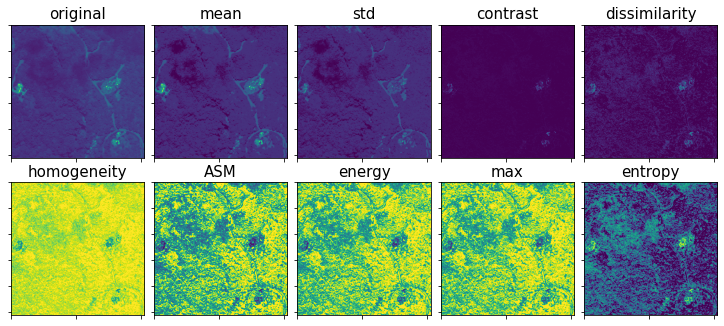

In [20]:
# coding: utf-8

import numpy as np
from skimage import data
from matplotlib import pyplot as plt

def main():
    pass


if __name__ == '__main__':
    main()

    img = image
    h,w = img.shape[0], img.shape[1]

    # The "ks" (Kernel Size) is a smoothing parameter.
    mean = fast_glcm_mean(img, ks=3)
    std = fast_glcm_std(img, ks=3)
    cont = fast_glcm_contrast(img, ks=3)
    diss = fast_glcm_dissimilarity(img, ks=3)
    homo = fast_glcm_homogeneity(img, ks=3)
    asm, ene = fast_glcm_ASM(img, ks=3)
    ma = fast_glcm_max(img, ks=3)
    ent = fast_glcm_entropy(img, ks=3)

    plt.figure(figsize=(10,4.5))
    fs = 15
    plt.subplot(2,5,1)
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.imshow(img)
    plt.title('original', fontsize=fs)

    plt.subplot(2,5,2)
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.imshow(mean)
    plt.title('mean', fontsize=fs)

    plt.subplot(2,5,3)
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.imshow(std)
    plt.title('std', fontsize=fs)

    plt.subplot(2,5,4)
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.imshow(cont)
    plt.title('contrast', fontsize=fs)

    plt.subplot(2,5,5)
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.imshow(diss)
    plt.title('dissimilarity', fontsize=fs)

    plt.subplot(2,5,6)
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.imshow(homo)
    plt.title('homogeneity', fontsize=fs)

    plt.subplot(2,5,7)
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.imshow(asm)
    plt.title('ASM', fontsize=fs)

    plt.subplot(2,5,8)
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.imshow(ene)
    plt.title('energy', fontsize=fs)

    plt.subplot(2,5,9)
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.imshow(ma)
    plt.title('max', fontsize=fs)

    plt.subplot(2,5,10)
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.imshow(ent)
    plt.title('entropy', fontsize=fs)

    plt.tight_layout(pad=0.5)
    plt.show()

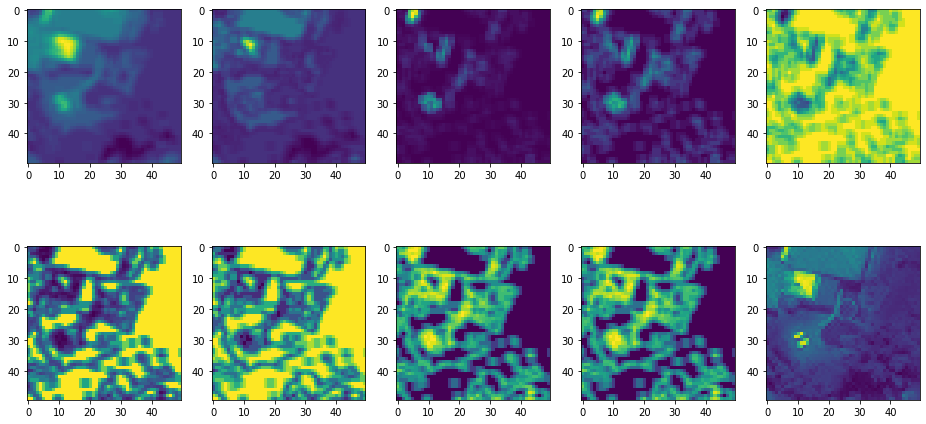

In [21]:
plt.figure(figsize=(16, 8))
plt.subplot(251), plt.imshow(mean[450:500, 800:850])
plt.subplot(252), plt.imshow(std[450:500, 800:850])
plt.subplot(253), plt.imshow(cont[450:500, 800:850])
plt.subplot(254), plt.imshow(diss[450:500, 800:850])
plt.subplot(255), plt.imshow(homo[450:500, 800:850])
plt.subplot(256), plt.imshow(asm[450:500, 800:850])
plt.subplot(257), plt.imshow(ma[450:500, 800:850])
plt.subplot(258), plt.imshow(ent[450:500, 800:850])
plt.subplot(259), plt.imshow(ent[450:500, 800:850])
plt.subplot(2,5,10), plt.imshow(image[450:500, 800:850])
plt.show()